## Geography-aware SSL for automatic brick kiln detection from satellite imagery TASK


### Overview
Initially we train EfficientNet model on 5% of the data and then test it on 50% of the test data. 
Then we create the jigsaw pre training dataset on 45% of the images.
Then the pretrained model is fine tuned on the 5% of images and tested on 50% of the data.
Additional experiments like using pretrained weights for EfficientNet and varying hyperparameters have been carried out.

#### Import Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor, Resize, Compose
from torchvision.utils import save_image
from PIL import Image
import os
from glob import glob
import cv2
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import os

Preparing DataLoaders

In [2]:
from torchvision.datasets import CIFAR10
transform = Compose([
    # Resize images to 33x33 to make it divisible by 3 for the later jigsaw task.
    Resize((33, 33)),
    ToTensor()
])
# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True,
                  transform=transform)

# Split dataset
train_size = int(0.05 * len(dataset))
pretrain_size = int(0.45 * len(dataset))
test_size = len(dataset) - train_size - pretrain_size
train_dataset, pretrain_dataset, test_dataset = random_split(
    dataset, [train_size, pretrain_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 35018724.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


### Initial training on 5% of the data

Initially using the efficient net model without pretraining.

In [3]:
from torchvision import models
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [5]:
# train on only 5% of the data
for epoch in range(25):  # loop over the dataset multiple times
    scheduler.step()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f, lr: %.6f' %
                  (epoch + 1, i + 1, running_loss / 10, scheduler.get_lr()[0]))
            running_loss = 0.0

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[1,    10] loss: 2.328, lr: 0.010000
[1,    20] loss: 2.358, lr: 0.010000
[1,    30] loss: 2.424, lr: 0.010000
[1,    40] loss: 2.430, lr: 0.010000
[1,    50] loss: 2.421, lr: 0.010000
[1,    60] loss: 2.342, lr: 0.010000
[1,    70] loss: 2.438, lr: 0.010000
[2,    10] loss: 2.264, lr: 0.010000
[2,    20] loss: 2.163, lr: 0.010000
[2,    30] loss: 2.278, lr: 0.010000
[2,    40] loss: 2.297, lr: 0.010000
[2,    50] loss: 2.296, lr: 0.010000
[2,    60] loss: 2.177, lr: 0.010000
[2,    70] loss: 2.174, lr: 0.010000
[3,    10] loss: 2.157, lr: 0.010000
[3,    20] loss: 2.228, lr: 0.010000
[3,    30] loss: 2.122, lr: 0.010000
[3,    40] loss: 2.103, lr: 0.010000
[3,    50] loss: 1.991, lr: 0.010000
[3,    60] loss: 2.131, lr: 0.010000
[3,    70] loss: 1.991, lr: 0.010000
[4,    10] loss: 2.012, lr: 0.010000
[4,    20] loss: 2.004, lr: 0.010000
[4,    30] loss: 2.090, lr: 0.010000
[4,    40] loss: 1.979, lr: 0.010000
[4,    50] loss: 2.113, lr: 0.010000
[4,    60] loss: 1.950, lr: 0.010000
[

In [6]:
# save the model state dict
torch.save(model.state_dict(),
           './cifar10_5percent_scheduler_pretrained_false.pth')

Using a pretrained (on imagenet) efficienet model

In [7]:
from torchvision import models
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 88.2MB/s]


In [8]:
# train on only 5% of the data
for epoch in range(25):  # loop over the dataset multiple times
    scheduler.step()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f, lr: %.6f' %
                  (epoch + 1, i + 1, running_loss / 10, scheduler.get_lr()[0]))
            running_loss = 0.0

[1,    10] loss: 2.318, lr: 0.010000
[1,    20] loss: 2.172, lr: 0.010000
[1,    30] loss: 2.034, lr: 0.010000
[1,    40] loss: 2.021, lr: 0.010000
[1,    50] loss: 2.026, lr: 0.010000
[1,    60] loss: 1.876, lr: 0.010000
[1,    70] loss: 2.031, lr: 0.010000
[2,    10] loss: 1.759, lr: 0.010000
[2,    20] loss: 1.972, lr: 0.010000
[2,    30] loss: 1.795, lr: 0.010000
[2,    40] loss: 1.794, lr: 0.010000
[2,    50] loss: 1.840, lr: 0.010000
[2,    60] loss: 1.696, lr: 0.010000
[2,    70] loss: 1.706, lr: 0.010000
[3,    10] loss: 1.655, lr: 0.010000
[3,    20] loss: 1.568, lr: 0.010000
[3,    30] loss: 1.538, lr: 0.010000
[3,    40] loss: 1.441, lr: 0.010000
[3,    50] loss: 1.573, lr: 0.010000
[3,    60] loss: 1.372, lr: 0.010000
[3,    70] loss: 1.548, lr: 0.010000
[4,    10] loss: 1.159, lr: 0.010000
[4,    20] loss: 1.298, lr: 0.010000
[4,    30] loss: 1.207, lr: 0.010000
[4,    40] loss: 1.203, lr: 0.010000
[4,    50] loss: 1.264, lr: 0.010000
[4,    60] loss: 1.099, lr: 0.010000
[

In [9]:
# save the model state dict
torch.save(model.state_dict(),
           './cifar10_5percent_scheduler_pretrained_true.pth')

Using adam optimiser (an attempt at hyperparameter tuning

In [10]:
from torchvision import models
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Using Adam optimizer
num_epochs = 25

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        #         inputs = reassemble_patches(inputs, grid_size=3)

        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

[1,    10] loss: 3.040
[1,    20] loss: 2.702
[1,    30] loss: 2.400
[1,    40] loss: 2.189
[1,    50] loss: 2.192
[1,    60] loss: 2.138
[1,    70] loss: 1.998
[2,    10] loss: 1.931
[2,    20] loss: 1.791
[2,    30] loss: 1.963
[2,    40] loss: 1.856
[2,    50] loss: 1.859
[2,    60] loss: 1.815
[2,    70] loss: 1.722
[3,    10] loss: 1.905
[3,    20] loss: 1.719
[3,    30] loss: 1.725
[3,    40] loss: 1.884
[3,    50] loss: 1.700
[3,    60] loss: 1.685
[3,    70] loss: 1.685
[4,    10] loss: 1.665
[4,    20] loss: 1.546
[4,    30] loss: 1.527
[4,    40] loss: 1.781
[4,    50] loss: 1.632
[4,    60] loss: 1.588
[4,    70] loss: 1.512
[5,    10] loss: 1.474
[5,    20] loss: 1.507
[5,    30] loss: 1.474
[5,    40] loss: 1.414
[5,    50] loss: 1.534
[5,    60] loss: 1.608
[5,    70] loss: 1.496
[6,    10] loss: 1.381
[6,    20] loss: 1.399
[6,    30] loss: 1.415
[6,    40] loss: 1.531
[6,    50] loss: 1.431
[6,    60] loss: 1.337
[6,    70] loss: 1.502
[7,    10] loss: 1.368
[7,    20] 

In [12]:
# save the model state dict
torch.save(model.state_dict(), './cifar10_5percent_adam_pretrained_true.pth')

## Image Jigsaw Puzzle Pretraining

In [13]:

from itertools import permutations
from torchvision.transforms import functional as F


def extract_patches(image, grid_size=3):
    patch_size = image.size(1) // grid_size
    patches = [F.crop(image, i, j, patch_size, patch_size)
               for i in range(0, image.size(1), patch_size)
               for j in range(0, image.size(2), patch_size)]
    return patches


def apply_permutation(patches, perm):
    return [patches[i] for i in perm]


# Example permutation generation (100 permutations)
num_permutations = 100
all_perms = np.array(list(permutations(range(9))))
selected_perms = all_perms[np.random.choice(
    len(all_perms), num_permutations, replace=False)]

In [14]:
from torch.utils.data import Dataset


class JigsawPuzzleDataset(Dataset):
    def __init__(self, dataset, permutations):
        self.dataset = dataset
        self.permutations = permutations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        perm_idx = np.random.choice(len(self.permutations))
        perm = self.permutations[perm_idx]
        shuffled_patches = apply_permutation(extract_patches(image), perm)
        # Convert list of patches to tensor
        shuffled_image = torch.stack(shuffled_patches)
        return shuffled_image, perm_idx


# Example usage
pretrain_dataset = JigsawPuzzleDataset(pretrain_dataset, selected_perms)

60


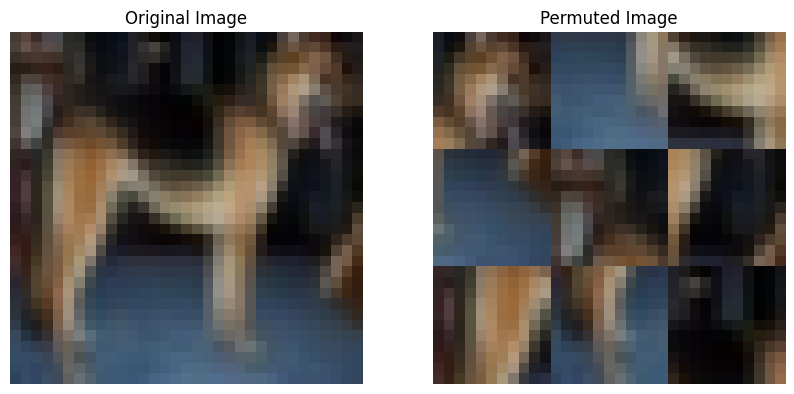

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms


def visualize_jigsaw(original_image, permuted_patches, grid_size=3):
    """
    Visualize the original and permuted image side by side.

    Args:
    original_image (Tensor): The original image tensor.
    permuted_patches (Tensor): The permuted patches tensor.
    grid_size (int): The size of the grid to divide the image into.
    """
    # Convert tensors to numpy arrays
    original_image = original_image.permute(1, 2, 0).numpy()

    # Reconstruct permuted image from patches
    patch_size = original_image.shape[0] // grid_size
    permuted_image = permuted_patches.view(
        grid_size, grid_size, 3, patch_size, patch_size)
    permuted_image = permuted_image.permute(0, 3, 1, 4, 2).contiguous()
    permuted_image = permuted_image.view(
        grid_size * patch_size, grid_size * patch_size, 3)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(permuted_image)
    axes[1].set_title("Permuted Image")
    axes[1].axis('off')

    plt.show()


# Example usage
# Assuming 'pretrain_jigsaw_dataset' is the JigsawPuzzleDataset instance
original_image, _ = pretrain_dataset.dataset[0]  # Get an original image
permuted_image, _ = pretrain_dataset[0]         # Get a permuted image
print(_)
visualize_jigsaw(original_image, permuted_image)

Using an EfficientNet model pretrained on ImageNet

In [16]:
from torchvision import models
# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)
# Modify the last layer for permutation prediction
num_ftrs = model.classifier[1].in_features
num_permutations = 100  # Assuming 100 permutations
model.classifier[1] = nn.Linear(num_ftrs, num_permutations)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
def reassemble_patches(patches, grid_size=3):
    """
    Reassemble the shuffled patches into a single image tensor.
    Converts 5d to 4d vector
    """
    batch_size, num_patches, channels, patch_height, patch_width = patches.shape
    patches = patches.view(batch_size, grid_size, grid_size,
                           channels, patch_height, patch_width)
    patches = patches.permute(0, 1, 4, 2, 5, 3).contiguous()
    patches = patches.view(batch_size, grid_size *
                           patch_height, grid_size * patch_width, channels)
    # Rearrange axes to [batch_size, channels, height, width]
    patches = patches.permute(0, 3, 1, 2)
    return patches

In [18]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Using Adam optimizer
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(pretrain_loader):
        inputs = reassemble_patches(inputs, grid_size=3)

        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

[1,    10] loss: 5.256
[1,    20] loss: 5.204
[1,    30] loss: 5.073
[1,    40] loss: 4.943
[1,    50] loss: 4.830
[1,    60] loss: 4.867
[1,    70] loss: 4.777
[1,    80] loss: 4.657
[1,    90] loss: 4.740
[1,   100] loss: 4.735
[1,   110] loss: 4.668
[1,   120] loss: 4.724
[1,   130] loss: 4.696
[1,   140] loss: 4.600
[1,   150] loss: 4.701
[1,   160] loss: 4.708
[1,   170] loss: 4.664
[1,   180] loss: 4.662
[1,   190] loss: 4.683
[1,   200] loss: 4.668
[1,   210] loss: 4.703
[1,   220] loss: 4.715
[1,   230] loss: 4.646
[1,   240] loss: 4.648
[1,   250] loss: 4.670
[1,   260] loss: 4.635
[1,   270] loss: 4.683
[1,   280] loss: 4.650
[1,   290] loss: 4.659
[1,   300] loss: 4.670
[1,   310] loss: 4.702
[1,   320] loss: 4.671
[1,   330] loss: 4.670
[1,   340] loss: 4.645
[1,   350] loss: 4.688
[1,   360] loss: 4.650
[1,   370] loss: 4.645
[1,   380] loss: 4.673
[1,   390] loss: 4.629
[1,   400] loss: 4.657
[1,   410] loss: 4.652
[1,   420] loss: 4.635
[1,   430] loss: 4.639
[1,   440] 

In [19]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

# Assuming the model is already defined and loaded as EfficientNet
# If not, you can load it as follows:
# model = models.efficientnet_b0(pretrained=False)
# And then load your trained weights if necessary

# Get the number of input features to the last layer
num_ftrs = model.classifier[1].in_features

# Reset the last layer for CIFAR-10 classification (10 classes)
model.classifier[1] = nn.Linear(num_ftrs, 10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer for fine-tuning
criterion = nn.CrossEntropyLoss()
# Using Adam optimizer, LR can be adjusted as needed
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Number of epochs for fine-tuning
num_fine_tune_epochs = 25

# Fine-tuning training loop
for epoch in range(num_fine_tune_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

[1,    10] loss: 2.293
[1,    20] loss: 2.169
[1,    30] loss: 2.059
[1,    40] loss: 1.867
[1,    50] loss: 1.851
[1,    60] loss: 1.950
[1,    70] loss: 1.914
[2,    10] loss: 1.801
[2,    20] loss: 1.748
[2,    30] loss: 1.620
[2,    40] loss: 1.664
[2,    50] loss: 1.650
[2,    60] loss: 1.740
[2,    70] loss: 1.670
[3,    10] loss: 1.519
[3,    20] loss: 1.647
[3,    30] loss: 1.502
[3,    40] loss: 1.421
[3,    50] loss: 1.441
[3,    60] loss: 1.544
[3,    70] loss: 1.484
[4,    10] loss: 1.467
[4,    20] loss: 1.409
[4,    30] loss: 1.465
[4,    40] loss: 1.384
[4,    50] loss: 1.338
[4,    60] loss: 1.269
[4,    70] loss: 1.388
[5,    10] loss: 1.341
[5,    20] loss: 1.223
[5,    30] loss: 1.343
[5,    40] loss: 1.247
[5,    50] loss: 1.171
[5,    60] loss: 1.269
[5,    70] loss: 1.194
[6,    10] loss: 1.282
[6,    20] loss: 1.093
[6,    30] loss: 1.081
[6,    40] loss: 1.192
[6,    50] loss: 1.069
[6,    60] loss: 1.275
[6,    70] loss: 1.249
[7,    10] loss: 1.132
[7,    20] 

In [20]:
torch.save(model.state_dict(), './pretrained.pth')

Using an EfficientNet model without pretraining on imagenet

In [21]:
from torchvision import models
# Load EfficientNet model
model = models.efficientnet_b0(pretrained=False)
# Modify the last layer for permutation prediction
num_ftrs = model.classifier[1].in_features
num_permutations = 100  # Assuming 100 permutations
model.classifier[1] = nn.Linear(num_ftrs, num_permutations)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Using Adam optimizer
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(pretrain_loader):
        inputs = reassemble_patches(inputs, grid_size=3)

        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

[1,    10] loss: 5.804
[1,    20] loss: 5.180
[1,    30] loss: 4.953
[1,    40] loss: 4.991
[1,    50] loss: 4.827
[1,    60] loss: 4.726
[1,    70] loss: 4.735
[1,    80] loss: 4.733
[1,    90] loss: 4.695
[1,   100] loss: 4.690
[1,   110] loss: 4.666
[1,   120] loss: 4.661
[1,   130] loss: 4.672
[1,   140] loss: 4.638
[1,   150] loss: 4.658
[1,   160] loss: 4.647
[1,   170] loss: 4.684
[1,   180] loss: 4.660
[1,   190] loss: 4.656
[1,   200] loss: 4.669
[1,   210] loss: 4.649
[1,   220] loss: 4.640
[1,   230] loss: 4.642
[1,   240] loss: 4.679
[1,   250] loss: 4.668
[1,   260] loss: 4.630
[1,   270] loss: 4.635
[1,   280] loss: 4.640
[1,   290] loss: 4.636
[1,   300] loss: 4.632
[1,   310] loss: 4.662
[1,   320] loss: 4.686
[1,   330] loss: 4.648
[1,   340] loss: 4.650
[1,   350] loss: 4.633
[1,   360] loss: 4.679
[1,   370] loss: 4.641
[1,   380] loss: 4.646
[1,   390] loss: 4.645
[1,   400] loss: 4.665
[1,   410] loss: 4.644
[1,   420] loss: 4.638
[1,   430] loss: 4.654
[1,   440] 

An interesting observation is that there is hardly any drop in training loss as compared to the one with transferred weights, indicating the neural network doesn't understand image feratures that well yet.

In [23]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

# Assuming the model is already defined and loaded as EfficientNet
# If not, you can load it as follows:
# model = models.efficientnet_b0(pretrained=False)
# And then load your trained weights if necessary

# Get the number of input features to the last layer
num_ftrs = model.classifier[1].in_features

# Reset the last layer for CIFAR-10 classification (10 classes)
model.classifier[1] = nn.Linear(num_ftrs, 10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer for fine-tuning
criterion = nn.CrossEntropyLoss()
# Using Adam optimizer, LR can be adjusted as needed
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Number of epochs for fine-tuning
num_fine_tune_epochs = 25

# Fine-tuning training loop
for epoch in range(num_fine_tune_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

[1,    10] loss: 2.320
[1,    20] loss: 2.316
[1,    30] loss: 2.317
[1,    40] loss: 2.326
[1,    50] loss: 2.309
[1,    60] loss: 2.302
[1,    70] loss: 2.311
[2,    10] loss: 2.310
[2,    20] loss: 2.355
[2,    30] loss: 2.309
[2,    40] loss: 2.365
[2,    50] loss: 2.303
[2,    60] loss: 2.269
[2,    70] loss: 2.329
[3,    10] loss: 2.312
[3,    20] loss: 2.301
[3,    30] loss: 2.236
[3,    40] loss: 2.258
[3,    50] loss: 2.249
[3,    60] loss: 2.226
[3,    70] loss: 2.226
[4,    10] loss: 2.152
[4,    20] loss: 2.197
[4,    30] loss: 2.100
[4,    40] loss: 2.153
[4,    50] loss: 2.193
[4,    60] loss: 2.111
[4,    70] loss: 2.119
[5,    10] loss: 2.268
[5,    20] loss: 2.244
[5,    30] loss: 2.226
[5,    40] loss: 2.196
[5,    50] loss: 2.205
[5,    60] loss: 2.215
[5,    70] loss: 2.186
[6,    10] loss: 2.157
[6,    20] loss: 2.153
[6,    30] loss: 2.141
[6,    40] loss: 2.121
[6,    50] loss: 2.138
[6,    60] loss: 2.075
[6,    70] loss: 2.133
[7,    10] loss: 2.098
[7,    20] 

In [24]:
torch.save(model.state_dict(), './notpretrained.pth')

In [32]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader

# Define the test_model function


def test_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    return accuracy


# List of model file paths
model_paths = [
    './cifar10_5percent_scheduler_pretrained_false.pth',
    './cifar10_5percent_adam_pretrained_true.pth',
    './cifar10_5percent_scheduler_pretrained_true.pth',
    './notpretrained.pth',
    './pretrained.pth'
]

# Loop through each model
for model_path in model_paths:
    # Load the EfficientNet-B0 model
    model = models.efficientnet_b0(pretrained=False)

    # Modify the classifier for CIFAR-10
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)

    # Load the model weights
    model.load_state_dict(torch.load(model_path))

    # Move the model to the device (e.g., GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Test the model
    accuracy = test_model(model, test_loader, device)

    # Print or store the accuracy for this model
    print(f'Model: {model_path}, Accuracy: {accuracy:.2f}%')

Model: /kaggle/working/cifar10_5percent_scheduler_pretrained_false.pth, Accuracy: 0.40%
Model: /kaggle/working/cifar10_5percent_adam_pretrained_true.pth, Accuracy: 0.55%
Model: /kaggle/working/cifar10_5percent_scheduler_pretrained_true.pth, Accuracy: 0.63%
Model: /kaggle/working/notpretrained.pth, Accuracy: 0.34%
Model: /kaggle/working/pretrained.pth, Accuracy: 0.48%


Observations:
* For training on 5% of the dataset best results are achieved when using pretrained model on imagenet that is 63% and 40% if not prior pretraining is done.
* After traning on jigsaw images and then finetuning the best accuracy is 48%. This model uses transferred weights from a pretrained efficientnet on imagenet. The one without any transferred weights gets an accuracy of 34%.
* Both the techniques achieve well over the baseline accuracy of 10%(random guessing).


Proposed Solutions to increase accuracy:


* By using the gap trick, we pad the input disordered images with zeros to the
size of original images. Adopting the gap trick can discourage all
the jigsaw puzzle solvers mentioned above from learning lowlevel
statistics, and encourage the learning of high-level visuospatial
representations of objects.

* Data Augmentation can help generalising more and improve the self supervised learning.
